In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

# Initial Setup

In [10]:
# Load data
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

In [11]:
# Caching jarak antar titik
distance_cache = {}

id2idx = {i: idx for idx, i in enumerate(ids)}

def get_weight(i, j):
    key = (i, j)
    if key in distance_cache:
        return distance_cache[key]
    # ambil index sekali, bukan ids.index(i) yang O(n)
    ii, jj = id2idx[i], id2idx[j]
    # euclidean
    dx = locations[ii][0] - locations[jj][0]
    dy = locations[ii][1] - locations[jj][1]
    d = float(np.hypot(dx, dy))
    distance_cache[(i, j)] = d
    distance_cache[(j, i)] = d
    return d

In [12]:
def total_distance(tour):
    distance = 0
    for i in range(len(tour) - 1):
        distance += get_weight(tour[i], tour[i + 1])
    distance += get_weight(tour[-1], tour[0])  # kembali ke kota awal
    return distance

# Contoh penggunaan
example = ids[:]
print("Contoh rute:", example)
print("Total jarak:", total_distance(example))

Contoh rute: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
Total jarak: 20412.639288624807


In [13]:
def split_ids(ids, num_vehicles):
    ids_copy = ids[:]
    random.shuffle(ids_copy)
    return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

In [14]:
def total_distance_multi(routes):
    return sum(total_distance(route) for route in routes if len(route) > 1)

# Clustering

Label kluster untuk tiap titik: [0 1 0 1 1 2 1 2 2 0 0 0 1 0 2 0 1 0 1 2 0 1 0 1 1 0 2 2 1 0 1 1 0 1 1 1 0
 2 2 0 1 2 0 1 1 0 0 2 0 0 0 0 1 2 1 1 1 1 0 0 2 1 0 0 2 0 1 2 1 1 1 1 0 1
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 2 1 0 0 1 0 0 0 1 1 2 2 0 2 1 2 2
 0 1 1 0 1 1 0 1 0 0 1 2 0 2 1 1 2 0 0 0 0 1 1 1 1 0 0 2 2 0 1 0]


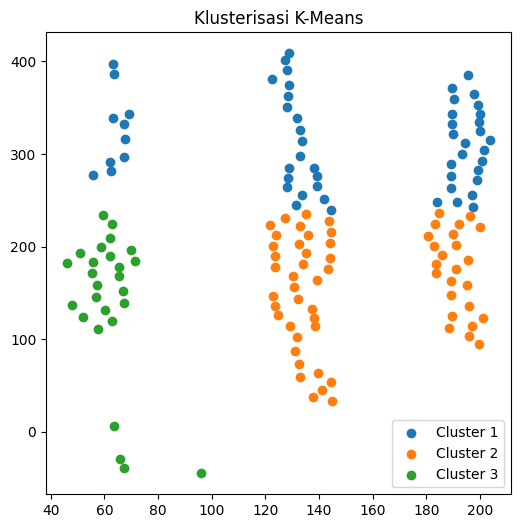

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(points, k, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    centroids = points[rng.choice(len(points), size=k, replace=False)].astype(float)

    for _ in range(max_iter):
        # assign ke centroid terdekat
        dists = np.linalg.norm(points[:, None, :] - centroids[None, :, :], axis=2)
        labels = dists.argmin(axis=1)

        # update centroid
        new_centroids = []
        for j in range(k):
            cluster_pts = points[labels == j]
            if len(cluster_pts) > 0:
                new_centroids.append(cluster_pts.mean(axis=0))
            else:
                new_centroids.append(points[rng.integers(0, len(points))])
        new_centroids = np.array(new_centroids)

        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return labels  # hanya label klaster

# --- contoh penggunaan ---
# locations = df[['x','y']].values
k = 3  # jumlah klaster
labels = kmeans(locations, k)

# hasil kluster: tiap titik punya label (0,1,2,...)
print("Label kluster untuk tiap titik:", labels)

# --- opsional: plot hasil kluster ---
plt.figure(figsize=(6,6))
for cluster_id in range(k):
    pts = locations[labels == cluster_id]
    plt.scatter(pts[:,0], pts[:,1], label=f"Cluster {cluster_id+1}")
plt.legend()
plt.title("Klusterisasi K-Means")
plt.show()

# ORTOOLS for Benchmarking

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def create_data_model(num_vehicles=1):
    matrix = [[get_weight(i, j) for j in ids] for i in ids]
    return {
        'distance_matrix': matrix,
        'num_vehicles': num_vehicles,
        'depot': 0,  # titik awal (bisa diganti)
    }

def solve_vrp(num_vehicles=1):
    data = create_data_model(num_vehicles)
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot']
    )
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(data['distance_matrix'][from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 16

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        routes = []
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route = []
            while not routing.IsEnd(index):
                route.append(ids[manager.IndexToNode(index)])
                index = solution.Value(routing.NextVar(index))
            route.append(ids[manager.IndexToNode(index)])  # kembali ke depot
            routes.append(route)
        cost = solution.ObjectiveValue()
        return routes, cost
    else:
        print("No solution found!")
        return None, float('inf')

# Contoh pemakaian:
routes, cost = solve_vrp(num_vehicles=1)
print("Total cost:", cost)
for i, route in enumerate(routes):
    print(f"Rute kendaraan {i+1}:", route)

Record for ORTOOLS: 1939m for 16s

# Lovebird Initial Algorithm

In [ ]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [ ]:
# Fungsi untuk RouletteWheel (untuk pemilihan titik secara probabilistik)
def roulette_wheel(population, fitness):
    total_fitness = sum(fitness)
    selection = random.uniform(0, total_fitness)
    current_sum = 0
    for i, individual in enumerate(population):
        current_sum += fitness[i]
        if current_sum >= selection:
            return individual
    return population[-1]  # fallback jika tidak ada yang terpilih

In [ ]:
# def lovebird_algorithm(maxGeneration, popSize, num_vehicles=1):
#     def split_ids(ids, num_vehicles):
#         ids_copy = ids[:]
#         random.shuffle(ids_copy)
#         return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

#     def total_distance_multi(routes):
#         return sum(total_distance(route) for route in routes if len(route) > 1)

#     population = [split_ids(ids, num_vehicles) for _ in range(popSize)]
#     best_solution = min(population, key=total_distance_multi)
#     best_fitness = total_distance_multi(best_solution)
#     history = [best_fitness]

#     for g in range(maxGeneration):
#         new_population = []
#         for i in range(popSize):
#             fitness = [1/total_distance_multi(ind) for ind in population]
#             individual = roulette_wheel(population, fitness)
#             T = copy.deepcopy(individual)

#             for v in range(num_vehicles):
#                 route = T[v]
#                 if len(route) > 1:
#                     rand = random.random()
#                     if rand < 0.9:
#                         i_idx, j_idx = sorted(random.sample(range(len(route)), 2))
#                         switch_case = random.choice([1, 2, 3, 4, 5])
#                         if switch_case == 1:
#                             route = swap_two(route, i_idx, j_idx)
#                         elif switch_case == 2:
#                             route = flip(route, i_idx, j_idx)
#                         elif switch_case == 3:
#                             route = interchange(route, i_idx, j_idx)
#                         elif switch_case == 4:
#                             route = slide(route, i_idx, j_idx)
#                         elif switch_case == 5:
#                             route = guided_swap(route, i_idx, j_idx)
#                     else:
#                         route = scramble(route)
#                 T[v] = route
#             new_population.append(T)

#         # Local search stacking: Swap sampai mentok, lalu Flip sampai mentok
#         improved = True
#         ls_sol = copy.deepcopy(best_solution)
#         while improved:
#             improved = False
#             # SWAP sampai tidak ada perbaikan
#             swap_found = True
#             while swap_found:
#                 swap_found = False
#                 for v in range(num_vehicles):
#                     route = ls_sol[v]
#                     if len(route) > 1:
#                         for i in range(len(route) - 1):
#                             for j in range(i + 1, len(route)):
#                                 candidate = swap_two(route, i, j)
#                                 temp_sol = ls_sol[:]
#                                 temp_sol[v] = candidate
#                                 if total_distance_multi(temp_sol) < total_distance_multi(ls_sol):
#                                     ls_sol[v] = candidate
#                                     swap_found = True
#                                     improved = True
#                                     break
#                             if swap_found:
#                                 break
#                     if swap_found:
#                         break
#             # FLIP sampai tidak ada perbaikan
#             flip_found = True
#             while flip_found:
#                 flip_found = False
#                 for v in range(num_vehicles):
#                     route = ls_sol[v]
#                     if len(route) > 1:
#                         for i in range(len(route) - 1):
#                             for j in range(i + 1, len(route)):
#                                 candidate = flip(route, i, j)
#                                 temp_sol = ls_sol[:]
#                                 temp_sol[v] = candidate
#                                 if total_distance_multi(temp_sol) < total_distance_multi(ls_sol):
#                                     ls_sol[v] = candidate
#                                     flip_found = True
#                                     improved = True
#                                     break
#                             if flip_found:
#                                 break
#                     if flip_found:
#                         break

#         # Update best_solution jika local search lebih baik
#         if total_distance_multi(ls_sol) < best_fitness:
#             best_solution = ls_sol
#             best_fitness = total_distance_multi(ls_sol)

#         # Evaluasi solusi baru
#         fitness = [1/total_distance_multi(individual) for individual in new_population]
#         best_fitness_in_generation = min([total_distance_multi(ind) for ind in new_population])
#         best_solution_in_generation = new_population[[total_distance_multi(ind) for ind in new_population].index(best_fitness_in_generation)]

#         if best_fitness_in_generation < best_fitness:
#             best_fitness = best_fitness_in_generation
#             best_solution = best_solution_in_generation

#         population = new_population
#         history.append(best_fitness)

#     return best_solution, best_fitness, history

In [ ]:
# # Contoh penggunaan lovebird_algorithm
# best_routes, best_cost, history = lovebird_algorithm(maxGeneration=50, popSize=30, num_vehicles=1)
# print("Total cost:", best_cost)
# for i, route in enumerate(best_routes):
#     print(f"Rute kendaraan {i+1}:", route)

In [ ]:
# # Plot history
# plt.figure(figsize=(8,4))
# plt.plot(history, marker='o')
# plt.title("Perkembangan Fitness Lovebird Algorithm")
# plt.xlabel("Generasi")
# plt.ylabel("Total Distance")
# plt.grid(True)
# plt.show()

# Local Lovebird Algorithm

In [ ]:
def lovebird_local_search(maxLoop, num_vehicles=1, initial_solution=None):
    current_solution = initial_solution if initial_solution else split_ids(ids, num_vehicles)
    current_fitness = 1 / total_distance_multi(current_solution)
    best_solution = current_solution
    best_fitness = current_fitness
    history = [1 / current_fitness]
    
    # no_improvement_count = 0  # Menghitung stagnasi
    
    for loop in range(maxLoop):
        new_solution = copy.deepcopy(current_solution)
        
        # Mutasi pada setiap rute kendaraan
        for v in range(num_vehicles):
            route = new_solution[v]
            if len(route) > 1:
                switch_case = random.choice([1, 2, 3, 4, 5])
                if switch_case == 1:
                    new_solution[v] = swap_two(route, random.randint(0, len(route)-1), random.randint(0, len(route)-1))
                elif switch_case == 2:
                    new_solution[v] = flip(route, random.randint(0, len(route)-1), random.randint(0, len(route)-1))
                elif switch_case == 3:
                    new_solution[v] = interchange(route, random.randint(0, len(route)-1), random.randint(0, len(route)-1))
                elif switch_case == 4:
                    new_solution[v] = slide(route, random.randint(0, len(route)-1), random.randint(0, len(route)-1))
                elif switch_case == 5:
                    new_solution[v] = guided_swap(route, random.randint(0, len(route)-1), random.randint(0, len(route)-1))

        new_fitness = 1 / total_distance_multi(new_solution)

        # Jika solusi baru lebih baik, terima solusi baru
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
            current_solution = new_solution
            # no_improvement_count = 0  # Reset stagnasi 
        # else:
        #     no_improvement_count += 1
        
        history.append(1 / best_fitness)

        # # Early stopping jika stagnasi terlalu lama
        # if no_improvement_count > 10000:  # Misalnya, 1000 iterasi tanpa perbaikan
        #     break

    return best_solution, 1 / best_fitness, history

In [ ]:
# Contoh penggunaan lovebird_local_search
best_routes, best_cost, history = lovebird_local_search(maxLoop=200000, num_vehicles=1)
print("Total cost:", best_cost)
for i, route in enumerate(best_routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 2167.0880049647567
Rute kendaraan 1: [30, 80, 130, 14, 63, 40, 97, 11, 66, 94, 52, 141, 16, 124, 101, 60, 131, 33, 56, 67, 135, 19, 104, 41, 96, 5, 121, 78, 107, 120, 50, 3, 88, 51, 64, 132, 12, 43, 76, 112, 26, 137, 49, 118, 75, 90, 23, 115, 47, 98, 73, 10, 102, 55, 117, 29, 122, 84, 127, 72, 85, 35, 134, 22, 77, 114, 142, 83, 13, 79, 69, 136, 109, 36, 58, 119, 70, 24, 126, 92, 32, 2, 86, 91, 44, 74, 17, 7, 62, 89, 103, 53, 133, 31, 93, 38, 9, 111, 28, 25, 71, 57, 4, 113, 82, 45, 99, 116, 87, 34, 106, 68, 125, 48, 6, 39, 108, 95, 20, 105, 128, 42, 139, 27, 61, 123, 65, 8, 140, 54, 110, 15, 81, 18, 59, 37, 100, 46, 138, 1, 143, 21, 129]


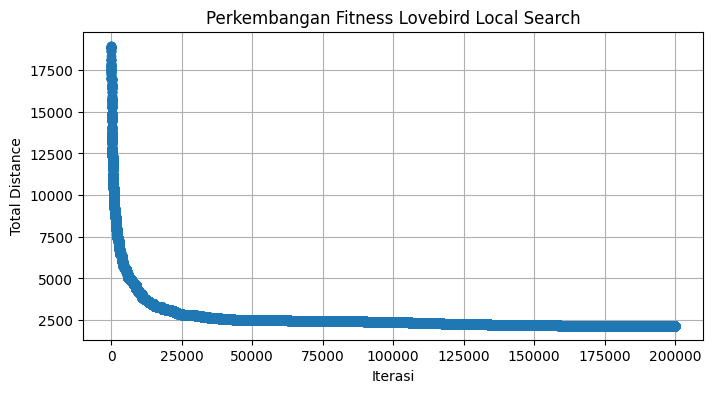

In [ ]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(history, marker='o')
plt.title("Perkembangan Fitness Lovebird Local Search")
plt.xlabel("Iterasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

# Iterated Lovebird

In [ ]:
# Perturbasi sederhana
def heavy_scramble(route, max_block=6):
    if len(route) < 2:
        return route[:]
    new = route[:]
    L = len(new)
    m = min(max_block, L)
    m = random.randint(2, m)           # panjang blok acak (>=2)
    i = random.randint(0, L - m)
    sub = new[i:i+m]
    random.shuffle(sub)
    return new[:i] + sub + new[i+m:]

def or_opt_intra(route, k=2):
    """Relocate blok k berurutan dalam rute yang sama."""
    L = len(route)
    if L < k + 1:
        return route[:]
    i = random.randint(0, L - k)          # ambil blok [i:i+k]
    j = random.randint(0, L - k)          # posisi penyisipan basis
    # pilih posisi sisip (boleh melewati blok asal, atur offset)
    if j >= i:
        j += k
    new = route[:i] + route[i+k:]
    j = min(j, len(new))                  # clamp
    block = route[i:i+k]
    return new[:j] + block + new[j:]

def perturb_multi_simple(solution, p_intra=0.9):
    sol = copy.deepcopy(solution)
    if random.random() < p_intra:
        idxs = [i for i, r in enumerate(sol) if len(r) >= 3]
        if idxs:
            v = random.choice(idxs)
            p = random.random()
            if p < 0.7 and len(sol[v]) >= 3:
                sol[v] = or_opt_intra(sol[v], k=2)   # 70%
            # elif p < 0.9 and len(sol[v]) >= 4:
            #     sol[v] = or_opt_intra(sol[v], k=3)   # 20%
            # else:
            #     sol[v] = heavy_scramble(sol[v], max_block=6)  # 10%
            else:
                sol[v] = or_opt_intra(sol[v], k=3)  # 30%
    else:
        non_empty = [i for i, r in enumerate(sol) if len(r) > 0]
        if len(non_empty) >= 2:
            a, b = random.sample(non_empty, 2)
            ia = random.randrange(len(sol[a]))
            ib = random.randrange(len(sol[b]))
            sol[a][ia], sol[b][ib] = sol[b][ib], sol[a][ia]
    return sol

# ILS sederhana (tanpa helper, tanpa normalisasi)
def iterated_lovebird(max_iter=30, local_gen=200, num_vehicles=1,
                      initial_solution=None):
    current = initial_solution if initial_solution else split_ids(ids, num_vehicles)

    # local search awal
    best_sol, best_cost, _ = lovebird_local_search(
        maxLoop=local_gen,
        num_vehicles=num_vehicles,
        initial_solution=current
    )
    history = [best_cost]

    for _ in range(max_iter):
        perturbed = perturb_multi_simple(best_sol)

        imp_sol, imp_cost, _ = lovebird_local_search(
            maxLoop=local_gen,
            num_vehicles=num_vehicles,
            initial_solution=perturbed
        )

        if imp_cost < best_cost - 1e-9:
            best_sol, best_cost = imp_sol, imp_cost

        history.append(best_cost)

    return best_sol, best_cost, history

In [ ]:
# Contoh penggunaan lovebird_local_search
best_routes, best_cost, history = iterated_lovebird(max_iter=50, local_gen=50000, num_vehicles=1)
print("Total cost:", best_cost)
for i, route in enumerate(best_routes):
    print(f"Rute kendaraan {i+1}:", route)

Total cost: 2234.56326094296
Rute kendaraan 1: [74, 17, 116, 99, 45, 82, 113, 4, 57, 71, 25, 28, 111, 9, 38, 93, 31, 133, 53, 103, 89, 7, 62, 22, 134, 77, 114, 35, 85, 72, 127, 79, 13, 83, 142, 24, 70, 136, 69, 96, 41, 104, 67, 56, 33, 131, 78, 121, 5, 117, 29, 84, 122, 55, 102, 10, 73, 98, 47, 107, 115, 23, 90, 75, 118, 49, 137, 26, 64, 51, 88, 3, 50, 120, 52, 124, 101, 60, 16, 141, 94, 66, 11, 97, 40, 132, 112, 76, 12, 43, 63, 14, 130, 80, 30, 129, 21, 143, 1, 138, 46, 100, 37, 59, 18, 81, 15, 110, 54, 140, 8, 65, 123, 105, 20, 108, 48, 106, 68, 125, 6, 39, 95, 128, 42, 139, 61, 27, 135, 19, 109, 36, 58, 119, 126, 92, 32, 2, 91, 86, 34, 87, 44]


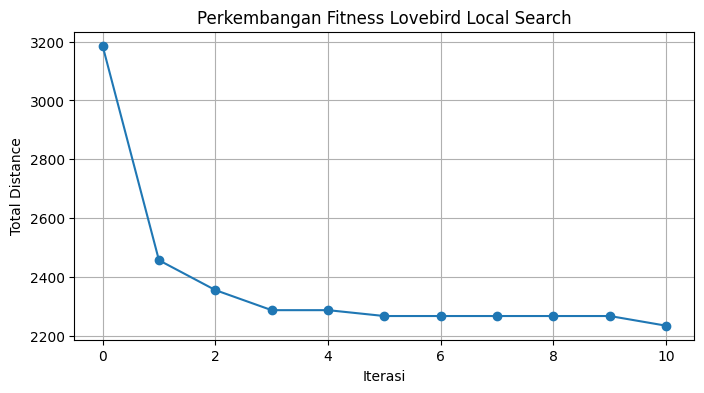

In [ ]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(history, marker='o')
plt.title("Perkembangan Fitness Lovebird Local Search")
plt.xlabel("Iterasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

# Testing

C:\Users\Raditya\AppData\Local\Temp\ipykernel_10192\568442081.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_ls, results_ils], labels=["Local Search", "ILS"])


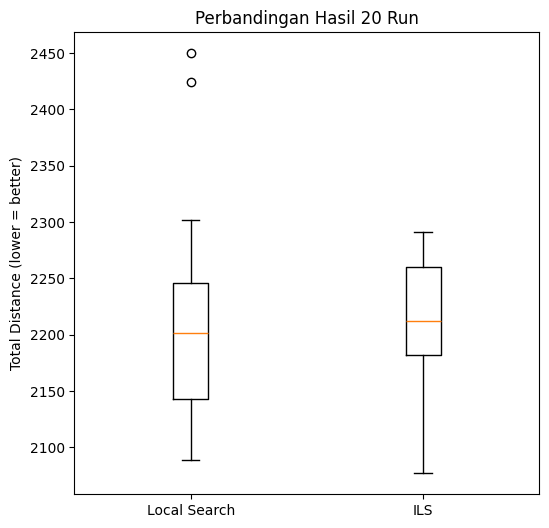

In [ ]:
# random.seed(42)
# np.random.seed(42)

# def experiment_boxplot(N=20):
#     results_ls = []   # hasil dari lovebird_local_search
#     results_ils = []  # hasil dari iterated_lovebird

#     for run in range(N):
#         # Jalankan Local Search
#         sol_ls, cost_ls, _ = lovebird_local_search(
#             maxLoop=300000,
#             num_vehicles=1,
#             initial_solution=None  # biar acak tiap run
#         )
#         results_ls.append(cost_ls)

#         # Jalankan ILS
#         sol_ils, cost_ils, _ = iterated_lovebird(
#             max_iter=10,
#             local_gen=25000,
#             num_vehicles=1,
#             initial_solution=None
#         )
#         results_ils.append(cost_ils)

#     # --- Boxplot ---
#     plt.figure(figsize=(6,6))
#     plt.boxplot([results_ls, results_ils], labels=["Local Search", "ILS"])
#     plt.ylabel("Total Distance (lower = better)")
#     plt.title(f"Perbandingan Hasil {N} Run")
#     plt.show()

#     return results_ls, results_ils

# # contoh pemanggilan
# results_ls, results_ils = experiment_boxplot(N=20)


In [ ]:
print("Rata-rata Local Search:", sum(results_ls)/len(results_ls))
print("Rata-rata ILS:", sum(results_ils)/len(results_ils))

Rata-rata Local Search: 2215.1378717039743
Rata-rata ILS: 2209.4695753518768
